In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

# Load the dataset
df = pd.read_csv('C:/Users/kunji/OneDrive/Desktop/data/augmented_arecanut_dataset5k.csv')

# Preprocessing function to convert scientific notation
def convert_scientific_notation(x):
    if isinstance(x, str) and 'x 10' in x:
        parts = x.split('x 10^')
        return float(parts[0]) * (10 ** int(parts[1]))
    return float(x)

# Convert scientific notation to float
df['Beneficial_Microbes (CFU/g)'] = df['Beneficial_Microbes (CFU/g)'].apply(convert_scientific_notation)
df['Harmful_Microbes (CFU/g)'] = df['Harmful_Microbes (CFU/g)'].apply(convert_scientific_notation)
df['Soil_Organic_Carbon'] = df['Soil_Organic_Carbon'].str.replace('%', '').astype(float) / 100.0

# Define numeric columns
numeric_cols = [
    'Soil_pH', 'N (Nitrogen)', 'P (Phosphorus)', 'K (Potassium)', 
    'Organic_Matter (kg compost)', 'Temperature (°C)', 'Rainfall (mm)', 
    'Elevation (m)', 'Beneficial_Microbes (CFU/g)', 'Harmful_Microbes (CFU/g)', 
    'Microbial_Biomass_C (g/kg)', 'Soil_Organic_Carbon'
]

# Convert to numeric and handle errors
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values with column means
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Split data into features and target variable, excluding Sample_ID
X = df.drop(['Crop_Yield (kg/palm)', 'Sample_ID'], axis=1)
y = df['Crop_Yield (kg/palm)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the Random Forest model with increased complexity
rf_model = RandomForestRegressor(
    n_estimators=500,   # Increased number of trees
    max_depth=15,       # Increased max depth
    min_samples_split=2,  # Reduced min samples to split to increase complexity
    min_samples_leaf=1,   # Allow leaves to have only one sample
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Predicting the yields for test data
y_pred = rf_model.predict(X_test_scaled)

# Calculate and print performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Accuracy Score (not standard for regression, but can provide context)
# In a regression context, you might use R^2 as the "accuracy"
accuracy = rf_model.score(X_test_scaled, y_test)
print(f"Model Accuracy (R^2): {accuracy:.2f}")

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Mean Squared Error: 0.11
Mean Absolute Error: 0.27
R^2 Score: 0.94
Model Accuracy (R^2): 0.94

Feature Importances:
                           Feature  Importance
9         Harmful_Microbes (CFU/g)    0.748960
12                Variety_SK Local    0.103596
21            Disease (Yes/No)_Yes    0.034371
8      Beneficial_Microbes (CFU/g)    0.019976
3                    K (Potassium)    0.009419
1                     N (Nitrogen)    0.008866
22        Disease_Name_Spindle Bug    0.008490
0                          Soil_pH    0.008339
13            Variety_Shreemangala    0.007670
4      Organic_Matter (kg compost)    0.007186
6                    Rainfall (mm)    0.007079
7                    Elevation (m)    0.006673
2                   P (Phosphorus)    0.005848
11      Microbial_Biomass_C (g/kg)    0.005555
14               Variety_Sumangala    0.005055
10             Soil_Organic_Carbon    0.003514
5                 Temperature (°C)    0.002747
24   Nutrient_Deficiency_Potassium    

In [2]:
# Example input for testing with disease conditions
test_input_data = {
    'Variety_SK Local': [0],
    'Variety_Shreemangala': [1],
    'Variety_Sumangala': [0],
    'Variety_Mangala': [0],  # Include Mangala variety only
    'Soil_pH': [6.2],
    'N (Nitrogen)': [102],
    'P (Phosphorus)': [53],
    'K (Potassium)': [159],
    'Organic_Matter (kg compost)': [13.2],
    'Temperature (°C)': [24],
    'Rainfall (mm)': [1526],
    'Elevation (m)': [576],
    'Beneficial_Microbes (CFU/g)': [convert_scientific_notation('1.8 x 10^7')],
    'Harmful_Microbes (CFU/g)': [convert_scientific_notation('0')],
    'Microbial_Biomass_C (g/kg)': [333],
    'Soil_Organic_Carbon': [2],
    'Microbial_Activity_Low': [0],
    'Microbial_Activity_Moderate': [0],
    'Microbial_Activity_High': [1],
    'Soil_Enzyme_Activity_Low': [0],
    'Soil_Enzyme_Activity_Moderate': [0],
    'Soil_Enzyme_Activity_High': [1],
    'Disease (Yes/No)_Yes': [0],  
    'Disease_Name_Koleroga': [0], 
    'Disease_Name_Spindle Bug': [0],
    'Nutrient_Deficiency_Nitrogen': [0],
    'Nutrient_Deficiency_Phosphorus': [0],
    'Nutrient_Deficiency_Potassium': [0],
    'Weather_Condition_Humid': [1],
    'Weather_Condition_Dry': [0],
    'Weather_Condition_Rainy': [0],
}


# Create a DataFrame for input
input_df = pd.DataFrame(test_input_data)

# Ensure the input DataFrame has the same structure as the training data
input_df = input_df.reindex(columns=X_train.columns, fill_value=0)

# Scale the input using the same scaler as during training
input_scaled = scaler.transform(input_df)

# Predict the yield using the trained Random Forest model
predicted_yield = rf_model.predict(input_scaled)
print(f"\nPredicted Crop Yield (kg/palm): {predicted_yield[0]:.2f}")



Predicted Crop Yield (kg/palm): 5.44


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn
sns.set(style='whitegrid')

C:\Users\kunji\AppData\Local\Temp\ipykernel_8236\3020961735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


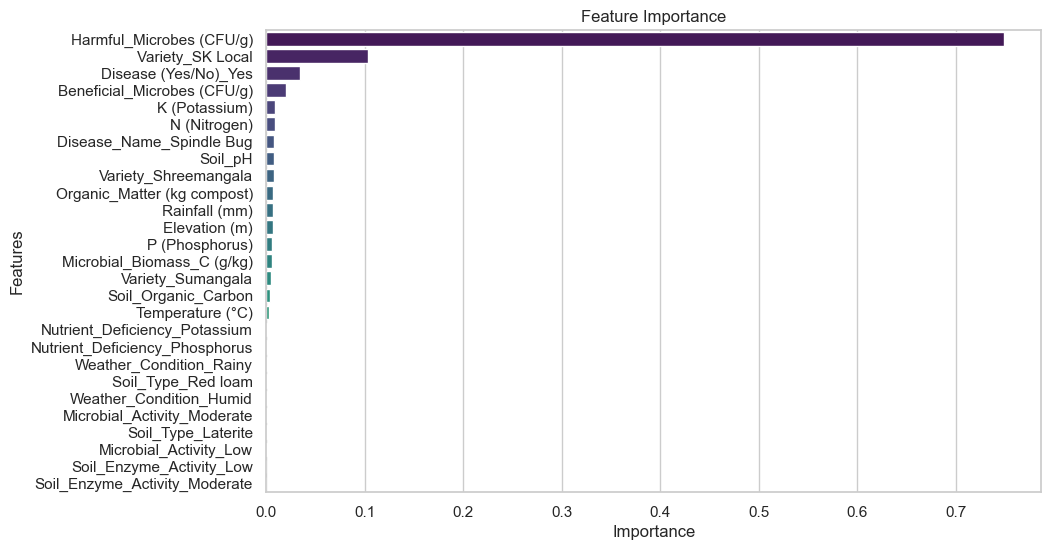

In [4]:
# 1. Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

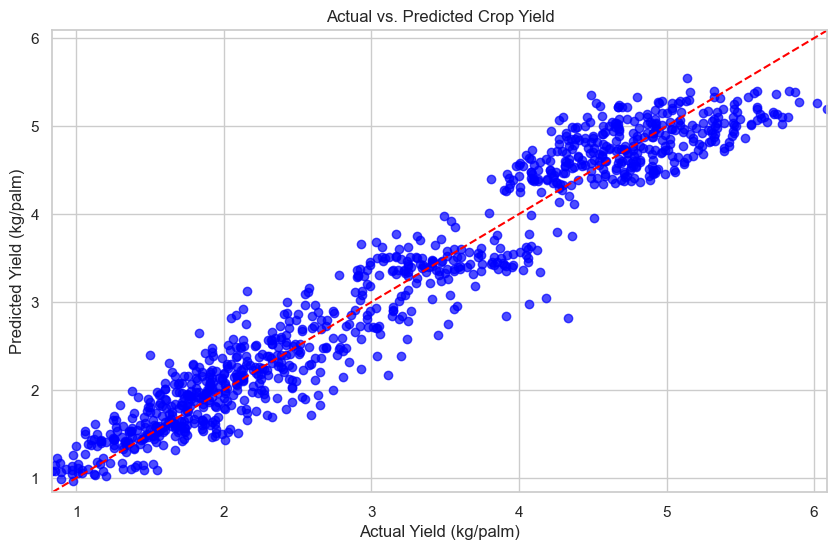

In [5]:
# 2. Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Actual vs. Predicted Crop Yield')
plt.xlabel('Actual Yield (kg/palm)')
plt.ylabel('Predicted Yield (kg/palm)')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.show()

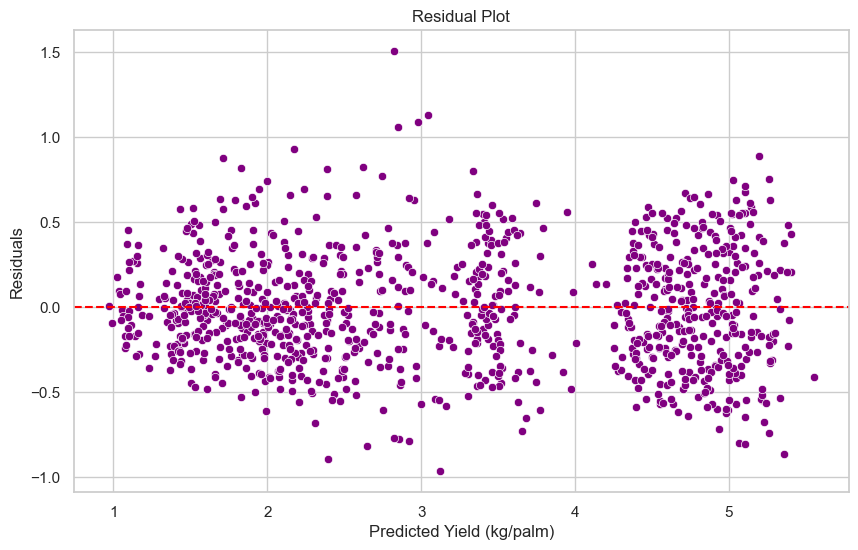

In [6]:
# 3. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residual Plot')
plt.xlabel('Predicted Yield (kg/palm)')
plt.ylabel('Residuals')
plt.show()

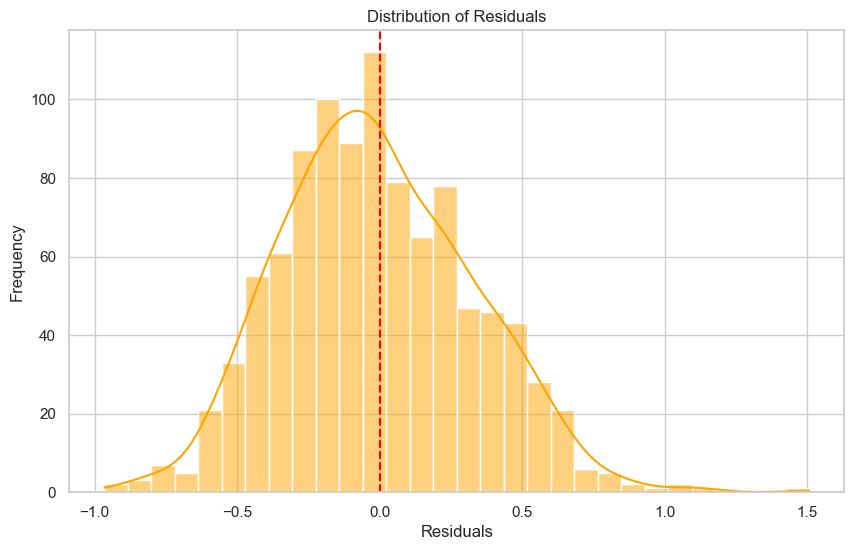

In [7]:
# 4. Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='orange')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

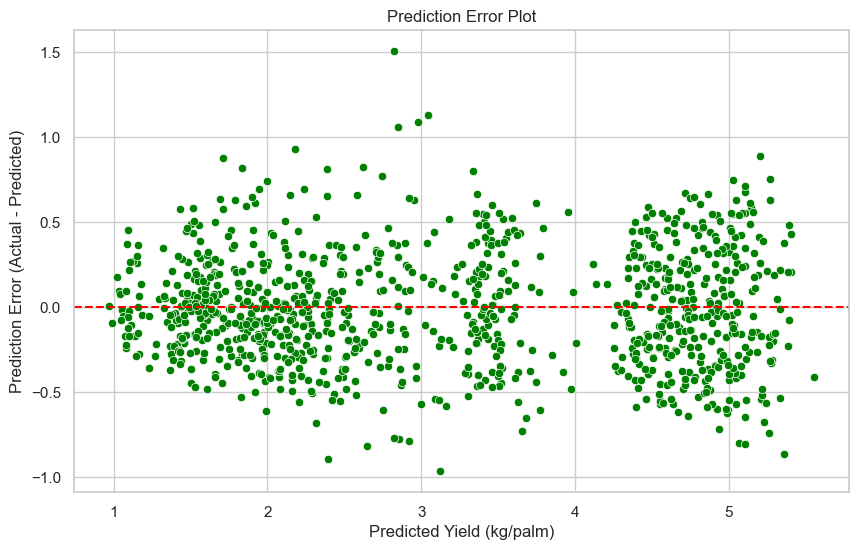

In [8]:
# 5. Prediction Error Plot
plt.figure(figsize=(10, 6))
error = y_test - y_pred
sns.scatterplot(x=y_pred, y=error, color='green')
plt.axhline(0, linestyle='--', color='red')
plt.title('Prediction Error Plot')
plt.xlabel('Predicted Yield (kg/palm)')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming y_test and y_pred are already defined from your model predictions

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

# Calculate adjusted R-squared
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of features
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r_squared:.2f}")
print(f"Adjusted R-squared: {adjusted_r_squared:.2f}")


Mean Absolute Error (MAE): 0.27
Mean Squared Error (MSE): 0.11
Root Mean Squared Error (RMSE): 0.34
R-squared: 0.94
Adjusted R-squared: 0.94


<Figure size 1000x600 with 0 Axes>

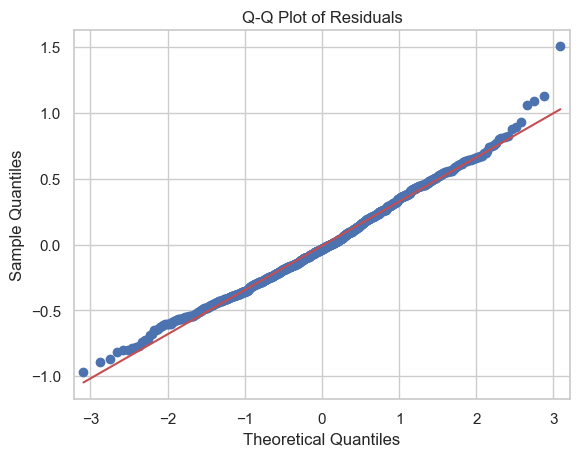

In [10]:
import statsmodels.api as sm

plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [11]:
from sklearn.model_selection import cross_val_score

# Define the model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")

Cross-validated RMSE: 0.35 ± 0.01


In [12]:
r_squared = r2_score(y_test, y_pred)

# Convert R-squared to percentage
r_squared_percentage = r_squared * 100

# Print R-squared as a percentage
print(f"R-squared: {r_squared_percentage:.2f}%")

R-squared: 94.14%


Mean Absolute Error: 0.27
Normalized Mean Absolute Error (NMAE): 0.0502
1 - Normalized Mean Absolute Error: 94.9836


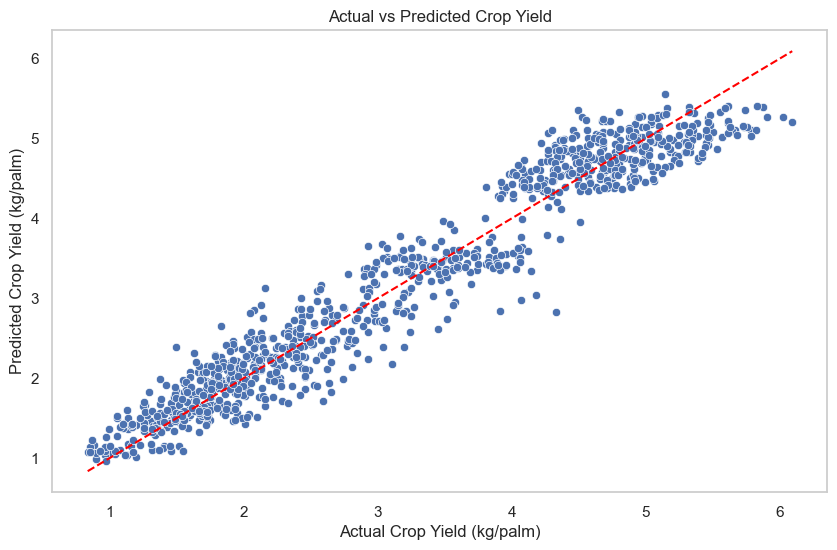

In [13]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

# Calculate Normalized Mean Absolute Error (NMAE)
nmae = mae / (y.max() - y.min())  # Normalize by the range of target variable
print(f"Normalized Mean Absolute Error (NMAE): {nmae:.4f}")

# Calculate 1 - NMAE
one_minus_nmae = 1 - nmae
print(f"1 - Normalized Mean Absolute Error: {(one_minus_nmae)*100:.4f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Crop Yield (kg/palm)')
plt.ylabel('Predicted Crop Yield (kg/palm)')
plt.title('Actual vs Predicted Crop Yield')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid()
plt.show()

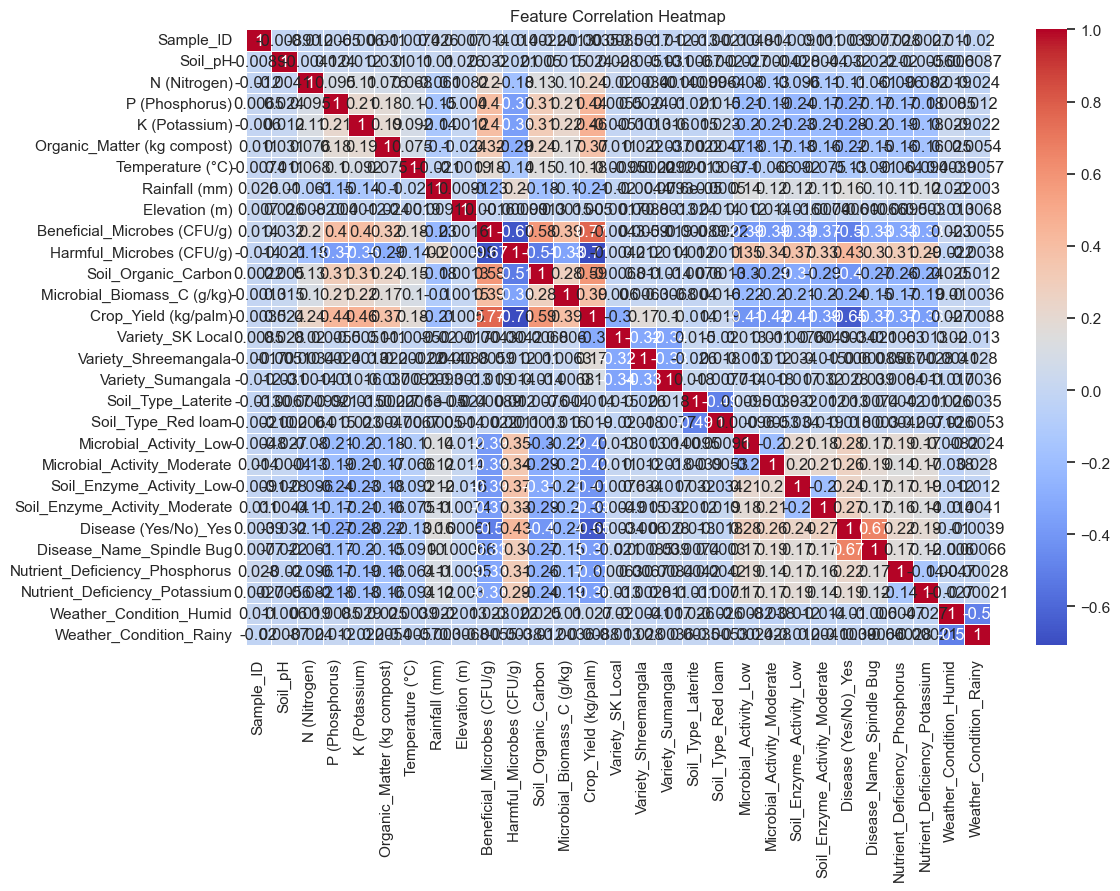

In [14]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

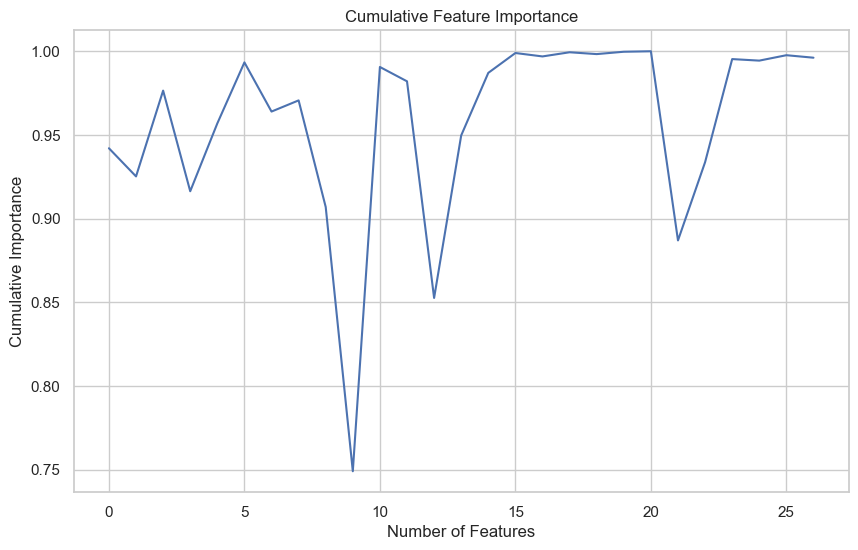

In [15]:
# Cumulative importance plot
feature_importances['Cumulative Importance'] = feature_importances['Importance'].cumsum()
plt.figure(figsize=(10, 6))
sns.lineplot(data=feature_importances, x=feature_importances.index, y='Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.show()